In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)
data = pd.read_csv('insurance.csv')
print(data.head())

file_size = os.path.getsize('insurance.csv') / (1024 * 1024)
print(f'Dataset size: {file_size:.2f} MB')

print(f'Number of entries: {data.shape[0]}')
print(f'Number of features: {data.shape[1]}')
categorical_columns = data.select_dtypes(include=['object']).columns
print(f'Categorical features: {list(categorical_columns)}')

missing_values = data.isnull().sum()
print(f'Missing values per column: \n{missing_values}')

print(f'\nBasic statistics:\n{data.describe()}')

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Dataset size: 0.05 MB
Number of entries: 1338
Number of features: 7
Categorical features: ['sex', 'smoker', 'region']
Missing values per column: 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Basic statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000 

In [ ]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train = [];
y_train = [];
X_test = [];
y_test = [];

Numeric columns: ['age', 'bmi', 'children', 'charges']
Categorical columns: ['sex', 'smoker', 'region']


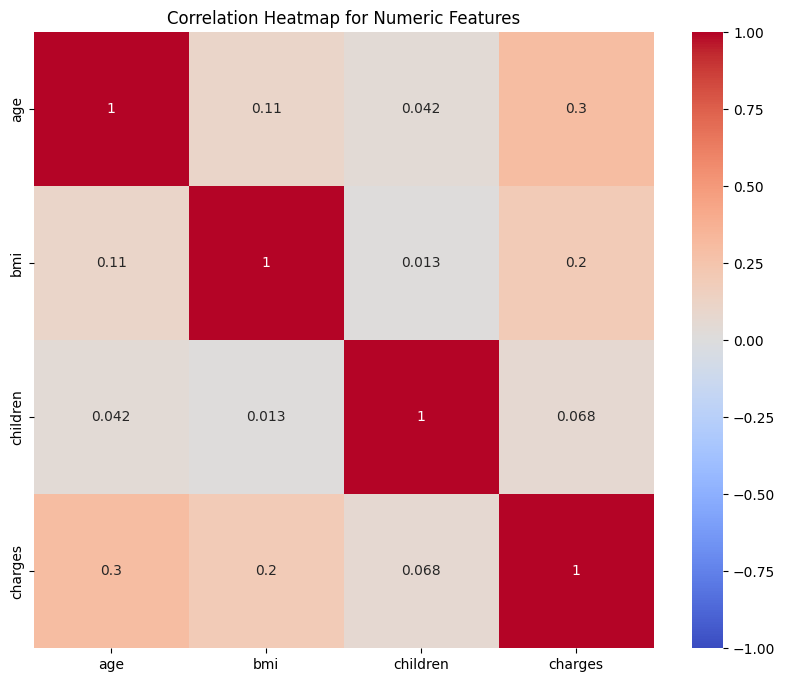


Correlations with 'charges':
charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(exclude=[np.number]).columns
print("Numeric columns:", list(numeric_columns))
print("Categorical columns:", list(categorical_columns))

# correlation matrix
corr_matrix = data[numeric_columns].corr()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap for Numeric Features')
plt.show()

print("\nCorrelations with 'charges':")
print(corr_matrix['charges'].sort_values(ascending=False))


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)
print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed test data:", X_test_processed.shape)

feature_names = (numerical_columns +
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_columns).tolist())

print("\nFeatures after preprocessing:", feature_names)

Shape of processed training data: (1070, 8)
Shape of processed test data: (268, 8)

Features after preprocessing: ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MyLinearRegression:

  def __init__ (self):
    self.theta = None
    self.alpha = None
    self.cost = []
    self.X_mean = None
    self.X_std = None

  def normalize_features(self, X):
    if self.X_mean is None or self.X_std is None:
      self.X_mean = np.mean(X, axis=0)
      self.X_std = np.std(X, axis=0)

    X_normalized = (X - self.X_mean) / (self.X_std + 1e-8)
    return np.column_stack((np.ones(X.shape[0]), X_normalized))

  def fitUsingGradientDescent(self, X_train, y_train, alpha=0.01, iters=1000):
    X_train = self.normalize_features(X_train)
    self.theta = np.zeros(X_train.shape[1])
    self.alpha = alpha
    self.theta, self.cost = self.gradientDescent(X_train, y_train, self.theta, self.alpha, iters)

  def fitUsingNormalEquation(self, X_train, y_train):
    #self.theta = [];
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values

    X_train = X_train.astype(float)
    y_train = y_train.astype(float)

    # column of 1's to X_train for the intercept term
    X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))

    XTX = X_train.T.dot(X_train)
    XTX_inv = np.linalg.pinv(XTX)
    self.theta = XTX_inv.dot(X_train.T).dot(y_train)

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    m = len(y_train)
    cost_history = []

    for _ in range(iters):
      h = X_train.dot(theta)
      gradient = (1/m) * X_train.T.dot(h - y_train)
      theta = theta - alpha * gradient

      cost = (1/(2*m)) * np.sum((h - y_train)**2)
      cost_history.append(cost)

      if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < 1e-8:
          break

    return theta, cost_history


  def predict(self, X_test):
    if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values
    X_test = X_test.astype(float)
    X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))
    y_predict = X_test.dot(self.theta)
    return y_predict

  def __str__(self):
    return "Parameter vector is %s" % self.theta

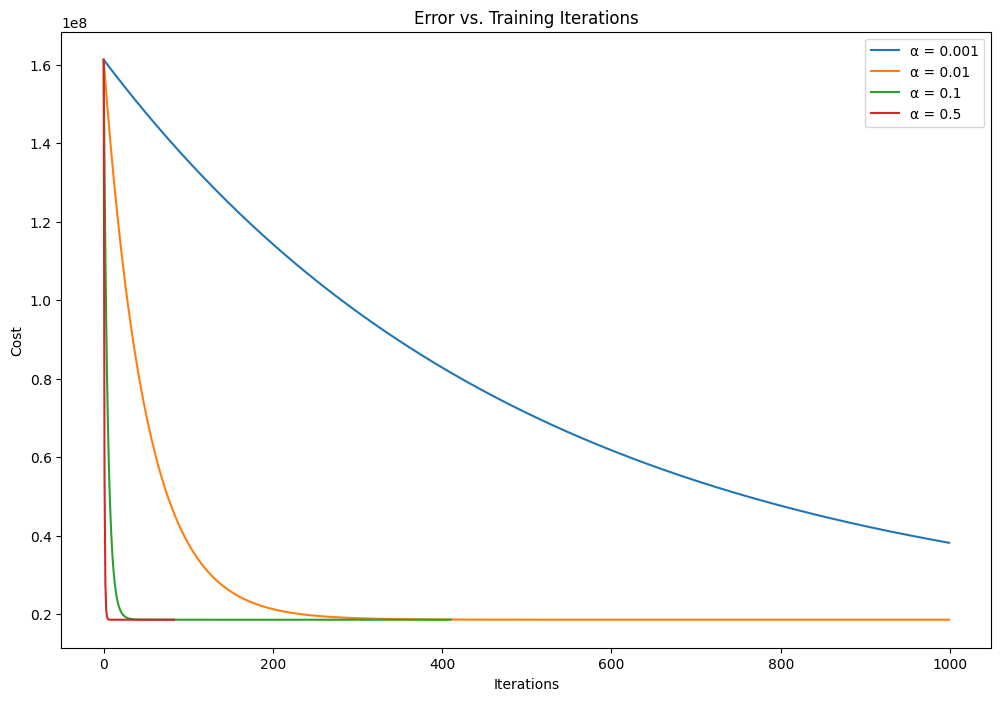

Final errors for each learning rate:
Learning rate 0.001: 38228521.22125678
Learning rate 0.01: 18638953.68965354
Learning rate 0.1: 18638840.851009507
Learning rate 0.5: 18638840.85100935

Best learning rate based on lowest final error: 0.5

Mean Squared Error: 33596915.90308169
Parameter vector is [ 1.33460897e+04  3.61497545e+03  2.03622810e+03  5.16890251e+02
 -9.29309896e+00  9.55848151e+03 -1.58140833e+02 -2.90156884e+02
 -3.49110526e+02]


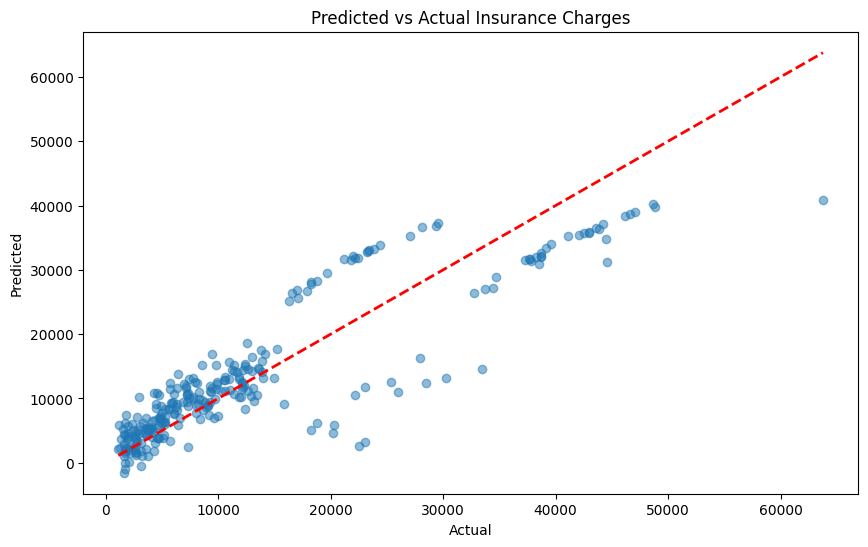

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('insurance.csv')
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def plot_learning_rates(X_train, y_train, learning_rates):
    plt.figure(figsize=(12, 8))
    final_errors = {}

    for alpha in learning_rates:
        model = MyLinearRegression()
        model.fitUsingGradientDescent(X_train, y_train, alpha=alpha)
        plt.plot(range(len(model.cost)), model.cost, label=f'α = {alpha}')
        final_errors[alpha] = model.cost[-1]

    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Error vs. Training Iterations')
    plt.legend()
    plt.show()

    return final_errors

learning_rates = [0.001, 0.01, 0.1, 0.5]
final_errors = plot_learning_rates(X_train_scaled, y_train, learning_rates)

print("Final errors for each learning rate:")
for alpha, error in final_errors.items():
    print(f"Learning rate {alpha}: {error}")

best_alpha = min(final_errors, key=final_errors.get)
print(f"\nBest learning rate based on lowest final error: {best_alpha}")

model = MyLinearRegression()
model.fitUsingGradientDescent(X_train_scaled, y_train, alpha=best_alpha)

y_pred = model.predict(X_test_scaled)

mse = np.mean((y_test - y_pred)**2)
print(f"\nMean Squared Error: {mse}")

print(model)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Insurance Charges')
plt.show()

Model Evaluation:
Training RMSE: $6105.55
Test RMSE: $5796.28
Training R^2: 0.7417
Test R^2: 0.7836

Model Coefficients (sorted by absolute value):
            Feature  Coefficient
4        smoker_yes  9558.481510
0               age  3614.975461
1               bmi  2036.228004
2          children   516.890248
7  region_southwest  -349.110121
6  region_southeast  -290.156449
5  region_northwest  -158.140443
3          sex_male    -9.293093
Intercept: 13346.09


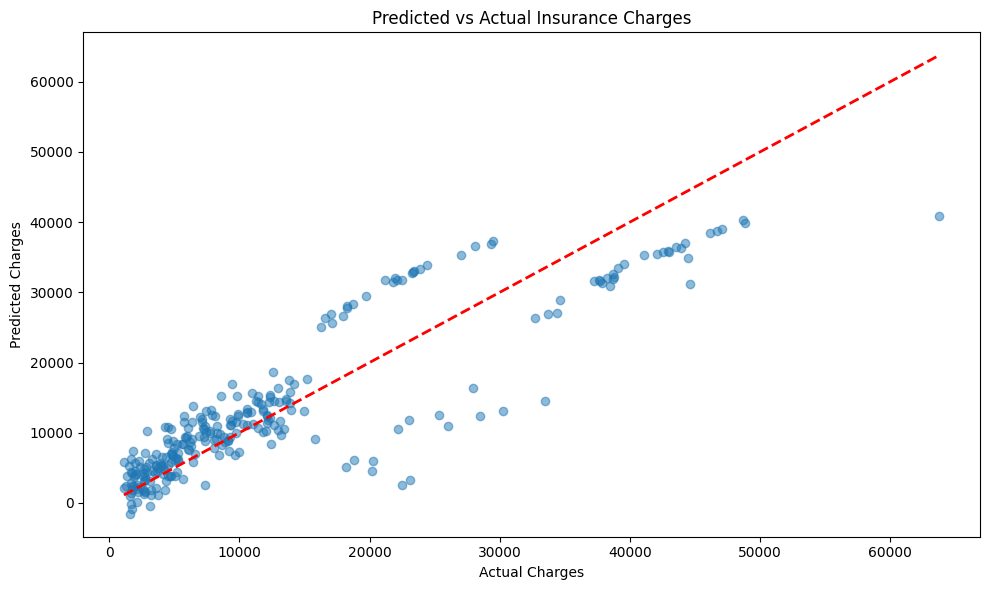

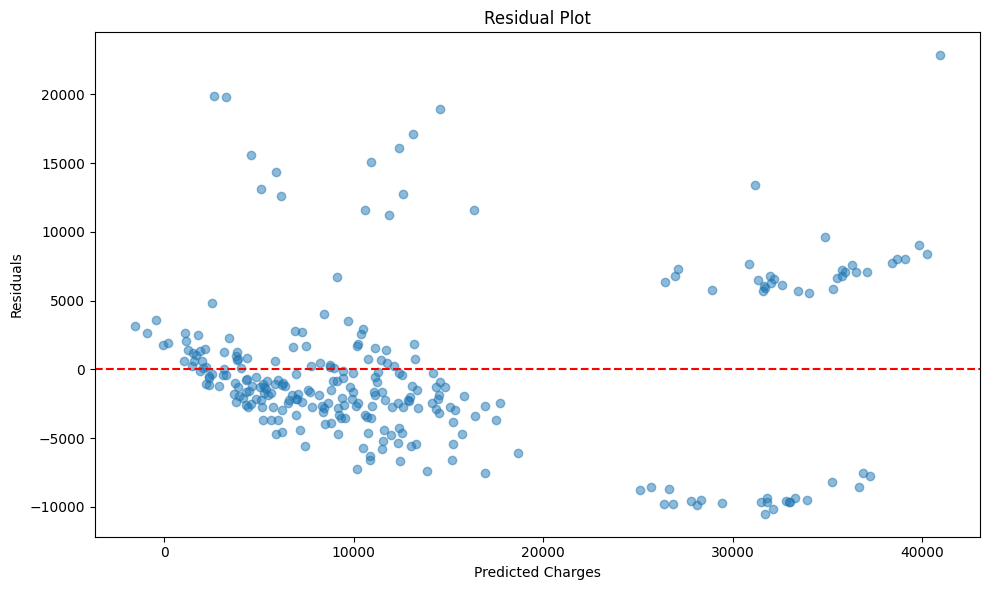

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

final_model = MyLinearRegression()
final_model.fitUsingGradientDescent(X_train_scaled, y_train, alpha=0.1, iters=1000)
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Evaluation:")
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

feature_names = X.columns
coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': final_model.theta[1:]})
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)
print("\nModel Coefficients (sorted by absolute value):")
print(coefficients)
print(f"Intercept: {final_model.theta[0]:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Predicted vs Actual Insurance Charges')
plt.tight_layout()
plt.show()

# residuals plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('insurance.csv')
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model using Normal Equation
normal_eq_model = MyLinearRegression()
normal_eq_model.fitUsingNormalEquation(X_train, y_train)

y_pred_normal = normal_eq_model.predict(X_test)
mse_normal = mean_squared_error(y_test, y_pred_normal)
r2_normal = r2_score(y_test, y_pred_normal)

print("Normal Equation Results:")
print(f"Mean Squared Error: {mse_normal}")
print(f"R-squared: {r2_normal}")
print("Model parameters:")
print(normal_eq_model)

# comparing with GD results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gd_model = MyLinearRegression()
gd_model.fitUsingGradientDescent(X_train_scaled, y_train, alpha=0.1, iters=1000)
y_pred_gd = gd_model.predict(X_test_scaled)

mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)

print("\nGradient Descent Results:")
print(f"Mean Squared Error: {mse_gd}")
print(f"R-squared: {r2_gd}")
print("Model parameters:")
print(gd_model)

# coefficients comparing
print("\nCoefficient Comparison:")
coeffs_normal = pd.DataFrame({'Feature': ['Intercept'] + list(X.columns), 'Normal Equation': normal_eq_model.theta})
coeffs_gd = pd.DataFrame({'Feature': ['Intercept'] + list(X.columns), 'Gradient Descent': gd_model.theta})
coeffs_comparison = pd.merge(coeffs_normal, coeffs_gd, on='Feature')
coeffs_comparison['Difference'] = coeffs_comparison['Normal Equation'] - coeffs_comparison['Gradient Descent']
print(coeffs_comparison)

Normal Equation Results:
Mean Squared Error: 33596915.85136149
R-squared: 0.7835929767120722
Model parameters:
Parameter vector is [-1.19312191e+04  2.56975706e+02  3.37092552e+02  4.25278784e+02
 -1.85916916e+01  2.36511289e+04 -3.70677326e+02 -6.57864297e+02
 -8.09799354e+02]

Gradient Descent Results:
Mean Squared Error: 33596916.20490833
R-squared: 0.7835929744347792
Model parameters:
Parameter vector is [ 1.33460897e+04  3.61497546e+03  2.03622800e+03  5.16890248e+02
 -9.29309318e+00  9.55848151e+03 -1.58140443e+02 -2.90156449e+02
 -3.49110121e+02]

Coefficient Comparison:
            Feature  Normal Equation  Gradient Descent    Difference
0         Intercept    -11931.219050      13346.089736 -25277.308787
1               age       256.975706       3614.975461  -3357.999755
2               bmi       337.092552       2036.228004  -1699.135452
3          children       425.278784        516.890248    -91.611464
4          sex_male       -18.591692         -9.293093     -9.298598
5

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor


data = pd.read_csv('insurance.csv')
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Descent
gd_model = MyLinearRegression()
gd_model.fitUsingGradientDescent(X_train_scaled, y_train, alpha=0.1, iters=1000)
y_pred_gd = gd_model.predict(X_test_scaled)
mse_gd = mean_squared_error(y_test, y_pred_gd)
rmse_gd = np.sqrt(mse_gd)

# Normal Equation
ne_model = MyLinearRegression()
ne_model.fitUsingNormalEquation(X_train, y_train)
y_pred_ne = ne_model.predict(X_test)
mse_ne = mean_squared_error(y_test, y_pred_ne)
rmse_ne = np.sqrt(mse_ne)

# SGD Regressor
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train_scaled, y_train)
y_pred_sgd = sgd_model.predict(X_test_scaled)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mse_sgd)

print("Root Mean Squared Error (RMSE) on test set:")
print(f"Gradient Descent: {rmse_gd:.2f}")
print(f"Normal Equation: {rmse_ne:.2f}")
print(f"SGD Regressor: {rmse_sgd:.2f}")

# best model
best_rmse = min(rmse_gd, rmse_ne, rmse_sgd)
if best_rmse == rmse_gd:
    best_model = "Gradient Descent"
elif best_rmse == rmse_ne:
    best_model = "Normal Equation"
else:
    best_model = "SGD Regressor"

print(f"\nBest performing model: {best_model} with RMSE of {best_rmse:.2f}")

# assessment of error
mean_charges = np.mean(y_test)
error_percentage = (best_rmse / mean_charges) * 100

print(f"\nMean charges in test set: ${mean_charges:.2f}")
print(f"Best RMSE as percentage of mean charges: {error_percentage:.2f}%")

if error_percentage < 10:
    assessment = "Good"
elif error_percentage < 30:
    assessment = "Okay"
else:
    assessment = "Needs improvement, terrible"

print(f"Personal Error assessment: {assessment}")


Root Mean Squared Error (RMSE) on test set:
Gradient Descent: 5796.28
Normal Equation: 5796.28
SGD Regressor: 5797.32

Best performing model: Normal Equation with RMSE of 5796.28

Mean charges in test set: $12968.32
Best RMSE as percentage of mean charges: 44.70%
Personal Error assessment: Needs improvement, terrible
